## **Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class params:

    data_path = '/content/drive/MyDrive/Project'
    bad_images = '/content/drive/MyDrive/Project/Bad'
    good_images = '/content/drive/MyDrive/Project/Good'
    csv_files = '/content/drive/MyDrive/Project/csv_files'

In [3]:
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

## **Dataset**



In [5]:
all_images = os.listdir(params.bad_images) + os.listdir(params.good_images)

In [13]:
dataset = pd.DataFrame(
    {
        'images': [f"{params.bad_images}/{x}" for x in os.listdir(params.bad_images)] + [f"{params.good_images}/{x}" for x in os.listdir(params.good_images)],
        'label': [0]*len(os.listdir(params.bad_images)) + [1]*len(os.listdir(params.good_images))
    }
)

In [14]:
dataset.head()

,images,label
0,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
1,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
2,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
3,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0
4,/content/drive/MyDrive/Project/Bad/IMG_2024021...,0


In [22]:
dataset['label'].value_counts(normalize = True)

1    0.773626
0    0.226374
Name: label, dtype: float64

In [16]:
X = dataset['images']
y = dataset['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((364,), (91,), (364,), (91,))

In [23]:
y_train.value_counts(normalize = True)

1    0.774725
0    0.225275
Name: label, dtype: float64

In [24]:
y_test.value_counts(normalize = True)

1    0.769231
0    0.230769
Name: label, dtype: float64

## **Feature Extration**

In [25]:
import cv2
import numpy as np
from skimage.feature import greycomatrix, graycoprops, graycomatrix
from skimage import io, color, img_as_ubyte
from skimage.feature import local_binary_pattern
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy

In [26]:
def ExtractFeatures(image_ids):
  """
  image_paths: Paths to the images
  """
  import time
  from tqdm import tqdm
  import warnings
  warnings.filterwarnings("ignore")

  features = {"image_id": [],
                "average_hue":[],
                "average_saturation": [],
                "average_value" : [],
                "area": [],
                "x":[], "y":[],
                "w":[], "h":[],
                "aspect_ratio": [],
                "correlation": [],
                "energy":[],
                "contrast":[],
                "homogeneity":[]}

  for image_id in tqdm(image_ids, desc="Processing", unit="images"):

    features["image_id"].append(image_id)
    image = cv2.imread(image_id)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Color Features
    average_color = np.mean(image, axis=(0, 1))
    color_histogram = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    dominant_color = np.argmax(color_histogram)
    color_variance = np.var(image)

    # 1. Average color in HSV channels (Hue, Saturation, Value)
    h, s, v,_ = cv2.mean(hsv)
    features["average_hue"].append(h)
    features["average_saturation"].append(s)
    features["average_value"].append(v)

    # 3. Area of the tomato (assuming some segmentation is done beforehand)
    # Replace this with your segmentation method (e.g., Otsu's thresholding)
    # This is a placeholder for demonstration purposes
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        largest_area = cv2.contourArea(contours[0])
        for cnt in contours:
          area = cv2.contourArea(cnt)
          if area > largest_area:
            largest_area = area
    else:
        largest_area = 0
    features["area"].append(largest_area)
    cnt = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    (x, y, w, h) = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h

    features["w"].append(w)
    features["h"].append(h)
    features["x"].append(x)
    features["y"].append(y)
    features["aspect_ratio"].append(aspect_ratio)

    glcm = graycomatrix(gray_image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    features["correlation"].append(correlation.mean())
    features["energy"].append(energy.mean())
    features["contrast"].append(contrast.mean())
    features["homogeneity"].append(homogeneity.mean())

  return pd.DataFrame(features)

In [27]:
## Extracting Training Dataset
features_df = ExtractFeatures(image_ids = X_train.values)

Processing: 100%|██████████| 364/364 [28:29<00:00,  4.70s/images]


In [28]:
features_df["quality"] = y_train.values
features_df.head()

,image_id,average_hue,average_saturation,average_value,area,x,y,w,h,aspect_ratio,correlation,energy,contrast,homogeneity,quality
0,/content/drive/MyDrive/Project/Good/IMG_202402...,187.932207,0.0,0.0,7306977.0,0,1790,3654,2684,1.361401,0.999488,0.074876,1.793483,0.575839,1
1,/content/drive/MyDrive/Project/Good/IMG_202402...,180.669479,0.0,0.0,9237372.0,928,2264,3014,4208,0.716255,0.999887,0.108073,0.558863,0.780224,1
2,/content/drive/MyDrive/Project/Good/IMG_202402...,191.237192,0.0,0.0,4354118.5,1699,2635,2352,2481,0.948005,0.999708,0.138788,0.837597,0.777061,1
3,/content/drive/MyDrive/Project/Good/IMG_202402...,190.373784,0.0,0.0,691646.0,1213,4233,2624,1181,2.221846,0.999591,0.114365,0.674852,0.775816,1
4,/content/drive/MyDrive/Project/Good/IMG_202402...,188.568423,0.0,0.0,7322388.0,1405,2007,3134,3432,0.913170,0.999814,0.125936,0.721641,0.776437,1


In [29]:
## Saving Training Dataset
features_df.to_csv(f"{params.csv_files}/Train.csv", index = False)

In [31]:
# ## Extracting Testing Dataset
features_test = ExtractFeatures(image_ids = X_test.values)

Processing: 100%|██████████| 91/91 [07:18<00:00,  4.81s/images]


In [33]:
features_test["quality"] = y_test.values
features_test.head()

,image_id,average_hue,average_saturation,average_value,area,x,y,w,h,aspect_ratio,correlation,energy,contrast,homogeneity,quality
0,/content/drive/MyDrive/Project/Good/IMG_202402...,179.851452,0.0,0.0,7296021.0,824,3596,3678,3635,1.011829,0.999756,0.081611,0.823700,0.738406,1
1,/content/drive/MyDrive/Project/Good/IMG_202402...,191.913994,0.0,0.0,3088412.5,775,3413,2512,2711,0.926595,0.999714,0.113779,0.547417,0.786155,1
2,/content/drive/MyDrive/Project/Good/IMG_202402...,178.457941,0.0,0.0,10826352.0,698,983,3959,5100,0.776275,0.999843,0.090454,0.709049,0.785638,1
3,/content/drive/MyDrive/Project/Good/IMG_202402...,188.550901,0.0,0.0,7126896.5,1327,2151,2948,3697,0.797403,0.999793,0.130636,0.599574,0.786861,1
4,/content/drive/MyDrive/Project/Bad/IMG_2024021...,175.528967,0.0,0.0,10869553.0,1237,2529,4266,4035,1.057249,0.999855,0.108519,0.929530,0.781898,0


In [34]:
# ## Saving Testing Dataset
features_test.to_csv(f"{params.csv_files}/Test.csv", index = False)

## **Reading CSV Files**

In [35]:
train_df = pd.read_csv(f"{params.csv_files}/Train.csv")
test_df = pd.read_csv(f"{params.csv_files}/Test.csv")

In [36]:
train_df.shape, test_df.shape

((364, 15), (91, 15))

In [37]:
train_df.head()

,image_id,average_hue,average_saturation,average_value,area,x,y,w,h,aspect_ratio,correlation,energy,contrast,homogeneity,quality
0,/content/drive/MyDrive/Project/Good/IMG_202402...,187.932207,0.0,0.0,7306977.0,0,1790,3654,2684,1.361401,0.999488,0.074876,1.793483,0.575839,1
1,/content/drive/MyDrive/Project/Good/IMG_202402...,180.669479,0.0,0.0,9237372.0,928,2264,3014,4208,0.716255,0.999887,0.108073,0.558863,0.780224,1
2,/content/drive/MyDrive/Project/Good/IMG_202402...,191.237192,0.0,0.0,4354118.5,1699,2635,2352,2481,0.948005,0.999708,0.138788,0.837597,0.777061,1
3,/content/drive/MyDrive/Project/Good/IMG_202402...,190.373784,0.0,0.0,691646.0,1213,4233,2624,1181,2.221846,0.999591,0.114365,0.674852,0.775816,1
4,/content/drive/MyDrive/Project/Good/IMG_202402...,188.568423,0.0,0.0,7322388.0,1405,2007,3134,3432,0.913170,0.999814,0.125936,0.721641,0.776437,1


## **Exploratory Data Analysis**

In [40]:
test_df['quality'].value_counts()

1    70
0    21
Name: quality, dtype: int64

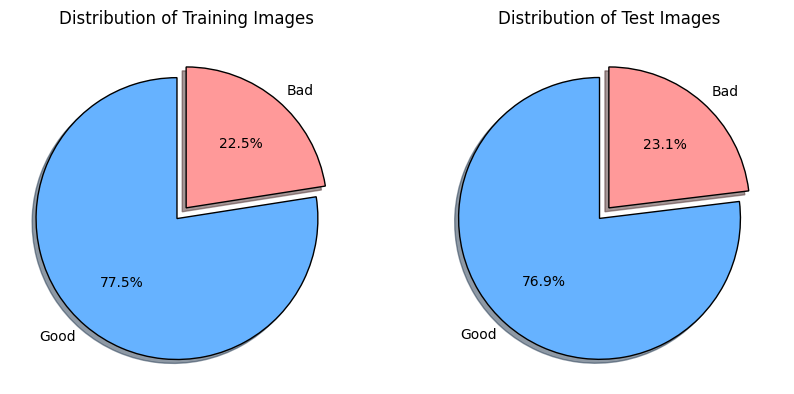

In [41]:
import matplotlib.pyplot as plt

# Sample data
labels = ['Good', 'Bad']
counts_train = [282, 82]  # Replace with your actual counts
counts_test = [70, 21]  # Replace with your actual counts

# Calculate percentages
total_count = sum(counts_train)
percentages_tr = [(count / total_count) * 100 for count in counts_train]
percentages_test = [(count / sum(counts_test)) * 100 for count in counts_test]

# Define pleasing colors
colors = ['#66b2ff', '#ff9999']

# Plotting the 2D pie chart with shadow
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
# Define the amount of explosion (0.1 means 10% of the radius)
explode = (0.1, 0)

ax[0].pie(percentages_tr, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops={'edgecolor': 'black'}, shadow=True, explode=explode)
# Add a title
ax[0].set_title('Distribution of Training Images')

ax[1].pie(percentages_test, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops={'edgecolor': 'black'}, shadow=True, explode=explode)
# Add a title
ax[1].set_title('Distribution of Test Images')

# Display the 2D pie chart with shadow
plt.show()

In [42]:
train_df.describe()

,average_hue,average_saturation,average_value,area,x,y,w,h,aspect_ratio,correlation,energy,contrast,homogeneity,quality
count,364.000000,364.0,364.0,3.640000e+02,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,182.383346,0.0,0.0,9.733640e+06,1085.796703,2371.763736,3624.741758,3787.510989,0.999664,0.999774,0.120142,0.965563,0.771811,0.774725
std,9.161995,0.0,0.0,3.927296e+06,522.006335,851.016549,793.888095,916.910537,0.278650,0.000135,0.023624,0.432667,0.035721,0.418338
min,153.329184,0.0,0.0,3.485920e+05,0.000000,0.000000,1365.000000,523.000000,0.506397,0.998691,0.069764,0.457268,0.568981,0.000000
25%,176.455830,0.0,0.0,7.217095e+06,785.750000,1870.750000,3132.000000,3238.750000,0.847065,0.999738,0.104358,0.659618,0.767440,1.000000
50%,183.646385,0.0,0.0,9.593140e+06,1053.000000,2343.500000,3627.000000,3832.500000,0.937688,0.999809,0.116824,0.819573,0.777933,1.000000
75%,189.821567,0.0,0.0,1.225806e+07,1375.500000,2774.250000,4139.750000,4337.250000,1.084221,0.999856,0.131996,1.134088,0.787670,1.000000
max,203.659817,0.0,0.0,2.225521e+07,3715.000000,5921.000000,5925.000000,7034.000000,3.001815,0.999924,0.212524,2.754430,0.808446,1.000000


In [43]:
import seaborn as sns

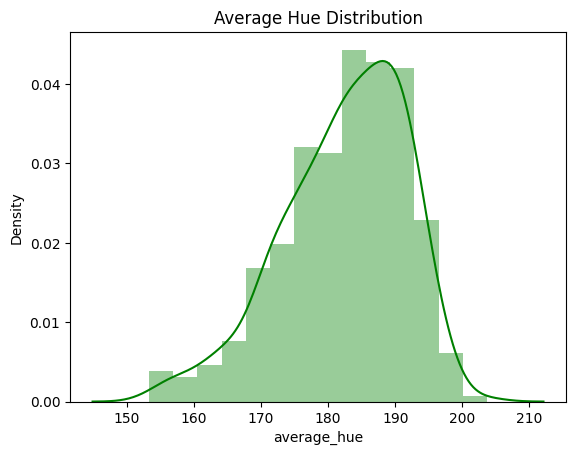

In [44]:
sns.distplot(train_df["average_hue"], color = "green")
plt.title("Average Hue Distribution")
plt.show()

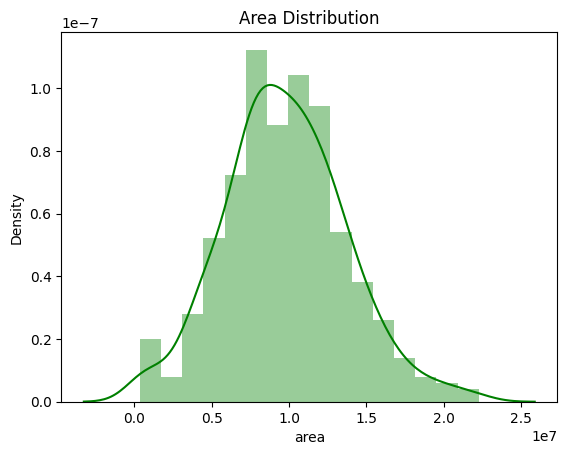

In [47]:
sns.distplot(train_df["area"], color = "green")
plt.title("Area Distribution")
plt.show()

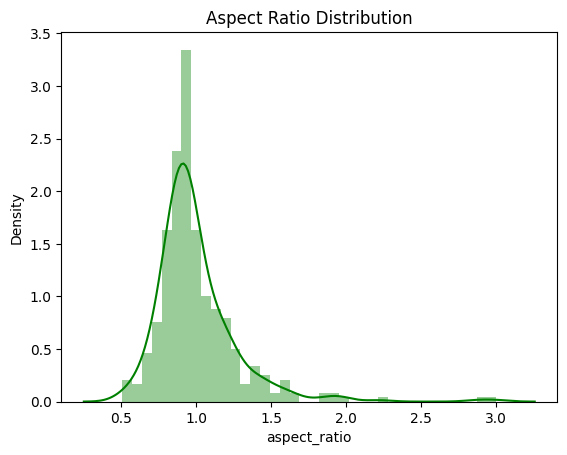

In [48]:
sns.distplot(train_df["aspect_ratio"], color = "green")
plt.title("Aspect Ratio Distribution")
plt.show()

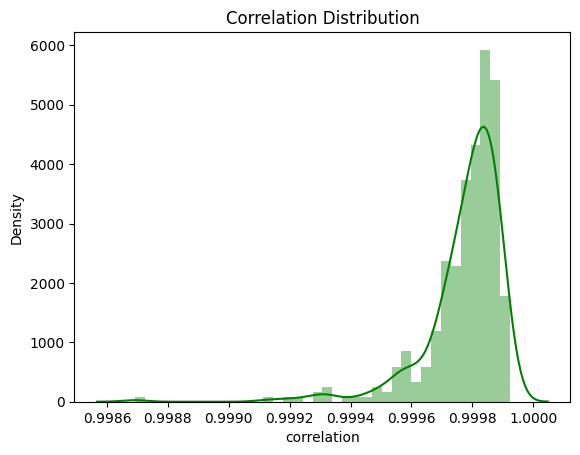

In [49]:
sns.distplot(train_df["correlation"], color = "green")
plt.title("Correlation Distribution")
plt.show()

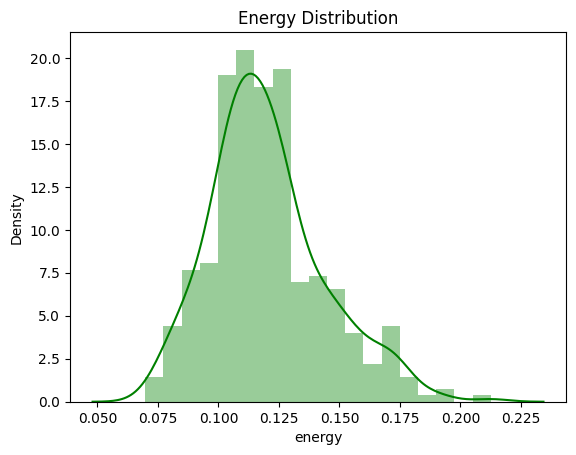

In [50]:
sns.distplot(train_df["energy"], color = "green")
plt.title("Energy Distribution")
plt.show()

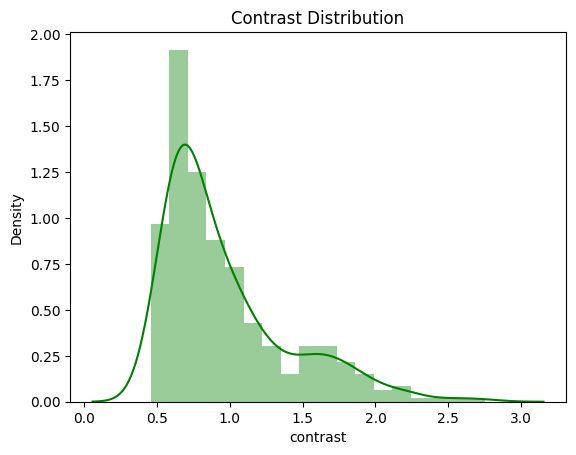

In [51]:
sns.distplot(train_df["contrast"], color = "green")
plt.title("Contrast Distribution")
plt.show()

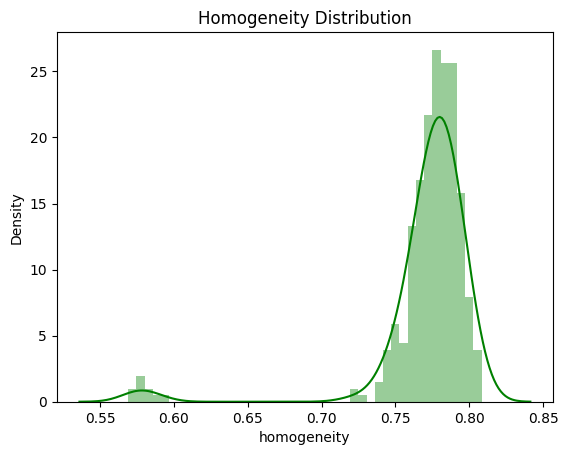

In [52]:
sns.distplot(train_df["homogeneity"], color = "green")
plt.title("Homogeneity Distribution")
plt.show()

## **Feature Engineering and Selection**

In [53]:
train_df.columns

Index(['image_id', 'average_hue', 'average_saturation', 'average_value',
       'area', 'x', 'y', 'w', 'h', 'aspect_ratio', 'correlation', 'energy',
       'contrast', 'homogeneity', 'quality'],
      dtype='object')

In [56]:
features = ['average_hue', 'area', 'aspect_ratio', 'correlation', 'energy', 'contrast', 'homogeneity', 'x', 'y', 'w', 'h']
target = ["quality"]

In [57]:
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [58]:
X_train.head(3)

,average_hue,area,aspect_ratio,correlation,energy,contrast,homogeneity,x,y,w,h
0,187.932207,7306977.0,1.361401,0.999488,0.074876,1.793483,0.575839,0,1790,3654,2684
1,180.669479,9237372.0,0.716255,0.999887,0.108073,0.558863,0.780224,928,2264,3014,4208
2,191.237192,4354118.5,0.948005,0.999708,0.138788,0.837597,0.777061,1699,2635,2352,2481


**Feature Scaling (Standardization)**

In [59]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()
scaler.fit(X_train)
# Fit the scaler to the data and transform the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
X_train

array([[ 0.60647261, -0.61874732,  1.29996602, ..., -0.68455133,
         0.03690509, -1.20516657],
       [-0.18732009, -0.12653786, -1.01848059, ..., -0.12680373,
        -0.77036351,  0.45922452],
       [ 0.96769675, -1.37166311, -0.18564573, ...,  0.30974556,
        -1.60538198, -1.42686696],
       ...,
       [ 1.56658393, -1.76009615, -0.08446899, ...,  0.43094388,
        -1.78323334, -1.66276491],
       [-0.42277044,  0.40741007, -0.22268611, ...,  0.50154484,
         0.28791518,  0.35110462],
       [ 0.55445894,  0.10557505, -0.43740103, ..., -0.68925806,
        -0.2077982 ,  0.16762844]])

## **Modeling**

**Logistics Regression**

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
model_log_reg = LogisticRegression()

# Train the model on the training data
model_log_reg.fit(X_train, y_train)

# Make predictions on the test data
pred_log_reg = model_log_reg.predict(X_test)

**SVC**

In [63]:
from sklearn.svm import SVC

In [64]:
model_svc = SVC()

# Train the model on the training data
model_svc.fit(X_train, y_train)

# Make predictions on the test data
pred_svc = model_svc.predict(X_test)

## **Model Evaluation**

In [76]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [80]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

**Models Accuracy**

In [66]:
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, pred_log_reg)}")
print(f"Support Vector Classifier Accuracy: {accuracy_score(y_test, pred_svc)}")

Logistic Regression Accuracy: 0.8021978021978022
Support Vector Classifier Accuracy: 0.7802197802197802


**Logistic Regression**

In [70]:
## Logistic Regression
print(classification_report(y_test, pred_log_reg))

              precision    recall  f1-score   support

           0       0.71      0.24      0.36        21
           1       0.81      0.97      0.88        70

    accuracy                           0.80        91
   macro avg       0.76      0.60      0.62        91
weighted avg       0.79      0.80      0.76        91



In [71]:
## Logistic Regression
confusion_matrix(y_test, pred_log_reg)

array([[ 5, 16],
       [ 2, 68]])

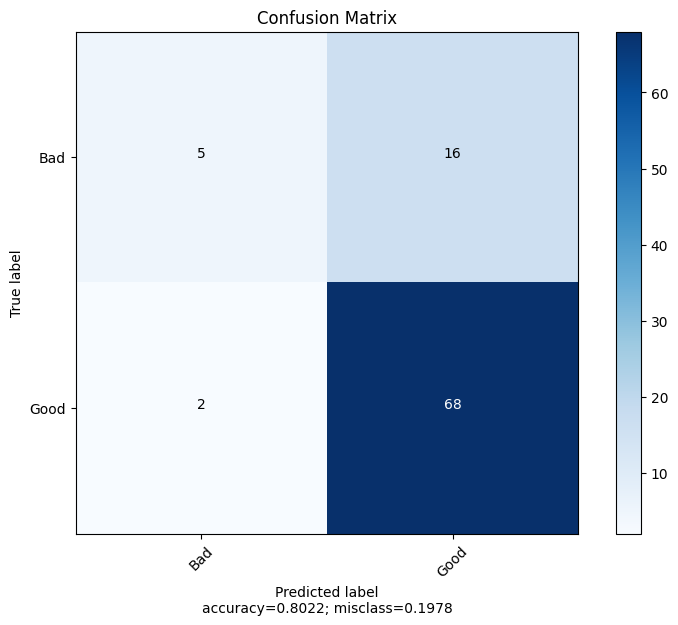

In [87]:
plot_confusion_matrix(cm           = confusion_matrix(y_test, pred_log_reg),
                      normalize    = False,
                      target_names = ['Bad', 'Good'],
                      title        = "Confusion Matrix")

**Support Vector Classifier**

In [90]:
## Logistic Regression
print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.05      0.09        21
           1       0.78      1.00      0.88        70

    accuracy                           0.78        91
   macro avg       0.89      0.52      0.48        91
weighted avg       0.83      0.78      0.69        91



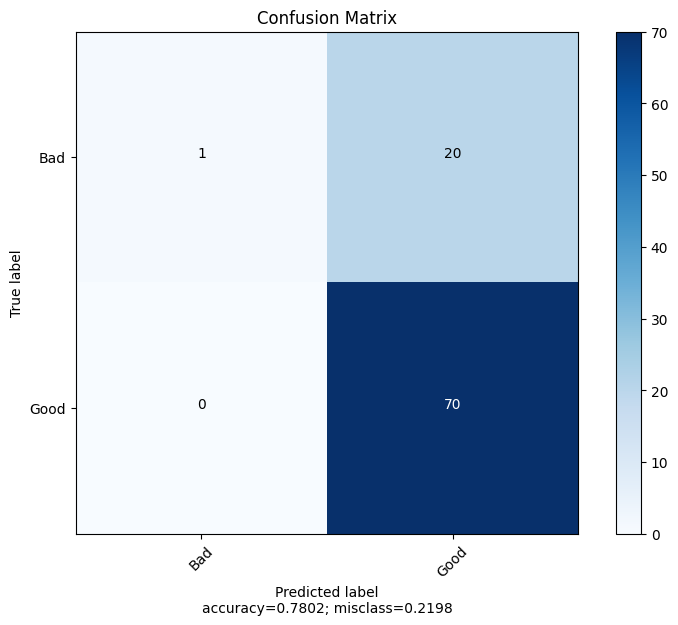

In [88]:
plot_confusion_matrix(cm           = confusion_matrix(y_test, pred_svc),
                      normalize    = False,
                      target_names = ['Bad', 'Good'],
                      title        = "Confusion Matrix")